# Purpose: Estimate, cumulate, and extrapolate and plot long wavelength radiative forcing from contrails, "other well mixed greenhouse gases", N2O, CH4, and CO2.

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import curve_fit
import csv
import scipy
import mpmath
from scipy.special import erf
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17Forcings')

Read the specified input file

In [2]:
df1 = pd.read_excel('heat18parameters06jan.xlsx')
df1.to_csv('heat18parameters06jan.csv',header=False,index=False)
df1 = pd.read_csv('heat18parameters06jan.csv')
# print (df1) 

In [3]:
b1 = df1.iloc[:,0:1]
b1 = b1['b1'].tolist()
b1 = list(map(float, b1))

b2 = df1.iloc[:,1:2]
b2 = b2['JulianYrEtc'].tolist()
b2 = list(map(float, b2))

b3 = df1.iloc[:,2:3]
b3 = b3['b3(Years)'].tolist()
b3 = list(map(float, b3))

b4 = df1.iloc[:,3:4]
b4 = b4['b4'].tolist()
b4 = list(map(float, b4))

Forcings

Contrails and Other Greenhouse Gases

In [4]:
def rad1(t):
     y = b1[12]/(1 + np.exp(-(t - b2[12])/b3[12]))
     return y

print(b1[11])

def rad2(t):
    y = b1[11]/(1 + np.exp(-(t - b2[11])/b3[11]))
    return y         

0.360664


N2O

In [5]:
def xn2o(t):
     y = (t - b2[10])/b3[10]
     return y

delta = b3[10]/b4[10]
        
def n2ofitindef(t):
     y = b1[10]*b3[10]*(np.log(1+np.exp(xn2o(t)))+delta*mpmath.polylog(2,-np.exp(xn2o(t)))-delta**2*mpmath.polylog(3,-np.exp(xn2o(t))))
     return y

t0 = 1750
tnow = 2017
# xn2o0 = xn2o(t0)
n2ofit0 = n2ofitindef(t0)
n2o0 = b3[19]

def n2ofit(t):
     y = n2o0 + n2ofitindef(t) - n2ofit0 + b1[22]/(1 + np.exp(-(t - b2[22])/b3[22]))
     return y

n2ofit = np.vectorize(n2ofit)

def rad3(t):
     y = b1[19] + b2[19]*(n2ofit(t) - b3[19])
     return y
 
# t = np.arange(t0,tnow+1)
# plt.plot(t,rad3(t))
    

CH4

In [6]:
ch40 = b3[18]
life = b4[8] #(* from heat17ch4emissions14dec.nb *)
eps = life/b3[8]
def x1(t):
     y = (t-b2[8])/b3[8]
     return y
def u(t):
     y = 1/(1 + np.exp(-x1(t)))
     return y

def ch4fit(t):
     y = ch40 + life*b1[8]*u(t)*(1-eps*(1-u(t))+eps**2*(1-u(t))*(1-2*u(t)))
#      y = ch40 + life*b1[8]*u(t)*(1-eps*(1-u(t))-eps**2*(1-u(t))*(1-2*u(t)))
     return y
def rad4(t):
     y = b1[18] + b2[18]*(ch4fit(t)-b3[18])
     return y

print (rad4(2010))


0.5060145021466682


CO2 from Land Use Changes

In [7]:
co20 = b3[17]
gtonnecperppm = 2.13;

def dlogint(t):
     y = b1[1]/(1 + np.exp(-(t - b2[1])/b3[1]))
     return y
dlogint0 = dlogint(t0)
# print (dlogint0)

def co2logintland(t):
     y = b4[1]*(dlogint(t) - dlogint0)/gtonnecperppm
     return y

def gaussint(t,b1g,b2g,b3g):
     y = b1g*b3g*np.sqrt(np.pi/2)*(-erf((b2g - t)/(b3g*np.sqrt(2))) + erf((b2g - t0)/(b3g*np.sqrt(2))))
     return y


bg = [] # results from co2 landuse fit from (g1 b1 d1) to (g4 b4 d4).
for i in range(3,7):
    sub_list=[]
    for m in range(0,3):
        x = df1.iloc[i,m].tolist()
        sub_list.append(float(x))
    bg.append(sub_list)
# print (bg)
# print (bg[0][0])

def gaussland(t):
     y = gaussint(t,bg[0][0],bg[0][1],bg[0][2])+gaussint(t,bg[1][0],bg[1][1],bg[1][2])+gaussint(t,bg[2][0],bg[2][1],bg[2][2])+gaussint(t,bg[3][0],bg[3][1],bg[3][2])
     return y

print (gaussland(2001))

def co2gauss(t):
     y = gaussland(t)/gtonnecperppm
     return y

def co2land(t):
     y = b4[3]*(co2logintland(t) + co2gauss(t))
     return y
# t = int(list(range(t0,tnow+1)))
# t = np.arange(t0,tnow+1)
# plt.plot(t,co2land(t))

def rad5(t):
     y = b1[17]+b2[17]*co2land(t)
     return y
# plt.figure()
# plt.plot(t,rad5(t))

print(rad5(2021))


57.9961083797746
0.6902493490808028


Industrial CO2

In [8]:
x0 = (t0-b2[2])/b3[2]

def x(t):
     y = (t-b2[2])/b3[2]
     return y

def co2ind(t):
     y = b4[3]*b4[4]*b1[2]*b3[2]*(np.log(1+np.exp(x(t)))-np.log(1+np.exp(x0)))/gtonnecperppm
     return y

print (b4[4])

def rad6(t):
     y = b1[17] + b2[17] * co2ind(t)
     return y


1.51518


Tropospheric ozone

In [9]:
def o3(t):
     y =  0.3046796148402036*np.exp(-0.0003741283886830488*(-2008.1969447572867+t)**2) + 42.160515888855294*(-0.0030623637478332457 + 0.021286138084796673*np.exp(0.006142015686708064*(2003.34-t))/(1+np.exp(0.006142015686708064*(2003.34 - t)))**2)
     return y

def rad1witho3(t):
     y = rad1(t)
     return y

def rad2witho3(t):
     y = o3(t)
     return y


def rad3witho3(t):
     y = rad2(t)
     return y

def rad4witho3(t):
     y = rad3(t)
     return y

def rad5witho3(t):
     y = rad4(t)
     return y

def rad6witho3(t):
     y = rad5(t)
     return y

def rad7witho3(t):
     y = rad6(t)
     return y

Summarize of Plots

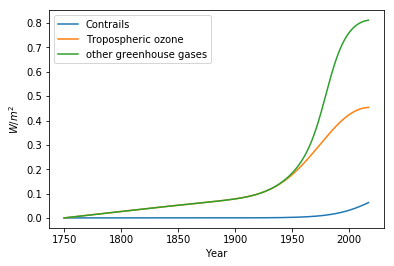

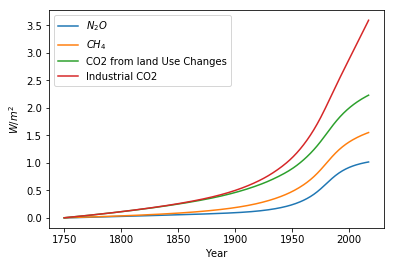

In [10]:
t = np.arange(t0,tnow+1)
plt.plot(t,rad1witho3(t),label ='Contrails')
plt.plot(t,rad1witho3(t)+rad2witho3(t), label ='Tropospheric ozone')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t), label ='other greenhouse gases')
plt.xlabel('Year')
plt.ylabel('$W/m^2$')
plt.legend(loc='best')
plt.savefig('sumforcings1.eps',dpi=1000)
plt.savefig('sumforcings1.pdf',dpi=1000)
plt.figure()

plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t), label ='$N_2O$')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t), label ='$CH_4$')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t), label ='CO2 from land Use Changes')
plt.plot(t,rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t)+rad7witho3(t), label ='Industrial CO2')
plt.xlabel('Year')
plt.ylabel('$W/m^2$')
plt.legend(loc='best')
plt.savefig('sumforcings2.eps',dpi=1000)
plt.savefig('sumforcings2.pdf',dpi=1000)

In [11]:
def fireall(t):
    y1 = rad1witho3(t)
    y2 = rad2witho3(t)
    y3 = rad3witho3(t)
    y4 = rad4witho3(t)
    y5 = rad5witho3(t)
    y6 = rad6witho3(t)
    y7 = rad7witho3(t)
    list  = [y1,y2,y3,float(y4),y5,y6,y7]
    return list

alpha = fireall(2000)
print (alpha)

[0.03138582452727275, 0.39234034970208304, 0.3369437051644243, 0.1569963233482686, 0.46256261522663905, 0.6176271240300769, 0.8886889673897774]


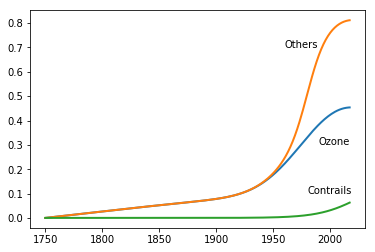

0.7606698793937801
0.42372617422935577
0.03138582452727275


In [12]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

t = np.arange(t0,tnow+1)
s1 = rad1witho3(t)+rad2witho3(t)
s2 = rad1witho3(t)+rad2witho3(t)+rad3witho3(t)
s3 = rad1witho3(t)
line, = ax.plot(t, s1, lw=2)
line1, = ax.plot(t, s2, lw=2)
line2, = ax.plot(t, s3, lw=2)

ax.annotate('Ozone', xy=(2000, 0.42372617422935577), xytext=(1990, 0.3))
ax.annotate('Others', xy=(2000, 0.7606698793937801), xytext=(1960, 0.7))
ax.annotate('Contrails', xy=(2000, 0.03138582452727275), xytext=(1980, 0.1))
plt.show()
print(rad1witho3(2000)+rad2witho3(2000)+rad3witho3(2000))
print(rad1witho3(2000)+rad2witho3(2000))
print(rad1witho3(2000))

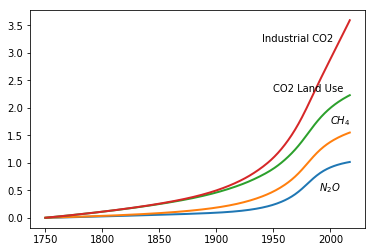

In [13]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)

s4 = rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)
s5 = rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)
s6 = rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t)
s7 = rad1witho3(t)+rad2witho3(t)+rad3witho3(t)+rad4witho3(t)+rad5witho3(t)+rad6witho3(t)+rad7witho3(t)
line3, = ax.plot(t, s4, lw=2)
line4, = ax.plot(t, s5, lw=2)
line5, = ax.plot(t, s6, lw=2)
line6, = ax.plot(t, s7, lw=2)

ax.annotate('$N_2O$', xy=(2000, 0.917666202742049), xytext=(1990, 0.5))
ax.annotate('$CH_4$', xy=(2000, 1.38022881796869), xytext=(2000, 1.7))
ax.annotate('CO2 Land Use', xy=(2000, 1.99785594199876), xytext=(1950, 2.3))
ax.annotate('Industrial CO2', xy=(2000, 2.88654490938854), xytext=(1940, 3.2))

plt.show()
# print(rad1witho3(2000)+rad2witho3(2000)+rad3witho3(2000)+rad4witho3(2000))
# print(rad1witho3(2000)+rad2witho3(2000)+rad3witho3(2000)+rad4witho3(2000)+rad5witho3(2000))
# print(rad1witho3(2000)+rad2witho3(2000)+rad3witho3(2000)+rad4witho3(2000)+rad5witho3(2000)+rad6witho3(2000))
# print(rad1witho3(2000)+rad2witho3(2000)+rad3witho3(2000)+rad4witho3(2000)+rad5witho3(2000)+rad6witho3(2000)+rad7witho3(2000))